<a href="https://colab.research.google.com/github/Stellalyf/Locating-and-Classifying-Chess-Pieces/blob/main/Test_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess CNN Model Testing

# 0. First Time Setup

### Install dependencies

In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --__version__# opencv is pre-installed on colab

# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

# install git-lfs so we can download the models
!sudo apt-get install git-lfs



Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 4.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 24.8 MB/s 
  Created wheel fo

### Download Dataset

In [ ]:
%mkdir dataset_chess
%cd ./dataset_chess
!curl -L  "https://public.roboflow.com/ds/aw6o6F7Nbc?key=oDcgTDubxK" > roboflow.zip ; 
print("Uncompressing...") 
!unzip -qq roboflow.zip; 
!rm roboflow.zip;
print("Data ready!")

/content/dataset_chess
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   888  100   888    0     0   2084      0 --:--:-- --:--:-- --:--:--  2084
100 18.6M  100 18.6M    0     0  25.9M      0 --:--:-- --:--:-- --:--:--  170M
Uncompressing...
Data ready!


### Download models

In [ ]:

%cd /content/
!git lfs install
!git clone https://github.com/Stellalyf/Locating-and-Classifying-Chess-Pieces.git

/content
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'Locating-and-Classifying-Chess-Pieces'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 70 (delta 11), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (70/70), done.
Filtering content: 100% (3/3), 1.39 GiB | 74.98 MiB/s, done.


# 1. Environment Setup

In [ ]:
# import common libraries
import numpy as np
import cv2
import random
import glob
import os
from google.colab.patches import cv2_imshow

# import detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader


In [ ]:
!CUDA_LAUNCH_BLOCKING=1

### Load dataset

In [ ]:
# Register dataset for detectron2
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/dataset_chess/train/_annotations.coco.json", "/content/dataset_chess/train")
register_coco_instances("my_dataset_val", {}, "/content/dataset_chess/valid/_annotations.coco.json", "/content/dataset_chess/valid")
register_coco_instances("my_dataset_test", {}, "/content/dataset_chess/test/_annotations.coco.json", "/content/dataset_chess/test")

WARNING [03/15 02:54:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/15 02:54:30 d2.data.datasets.coco]: Loaded 606 images in COCO format from /content/dataset_chess/train/_annotations.coco.json


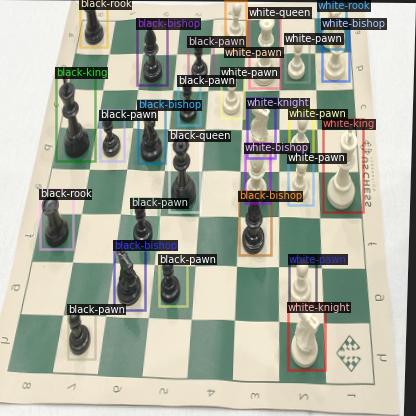

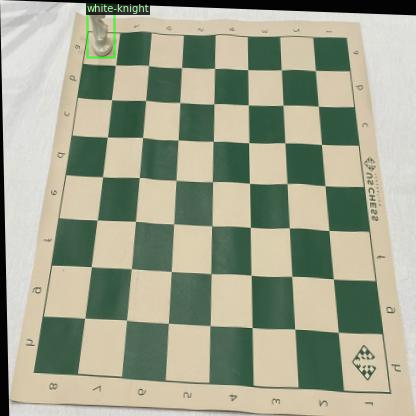

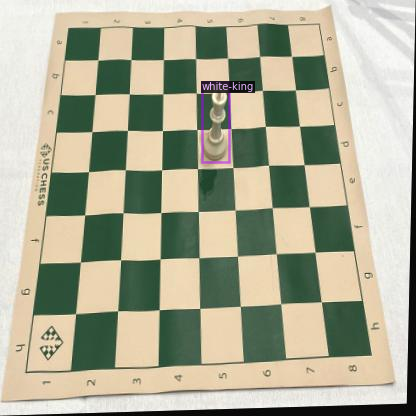

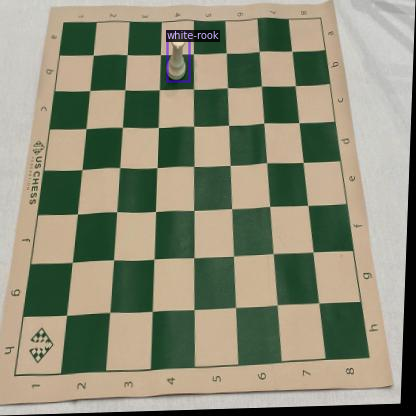

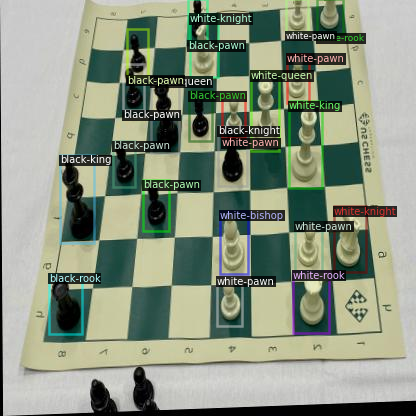

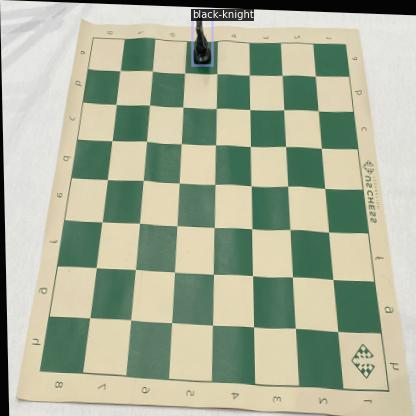

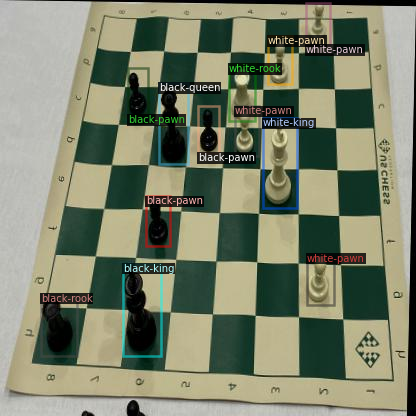

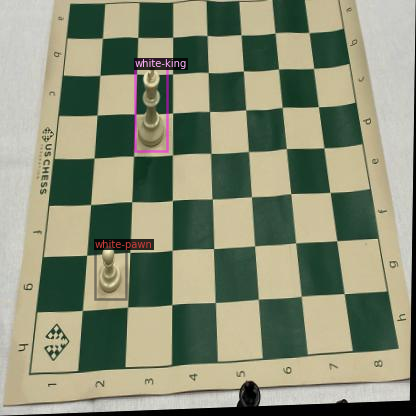

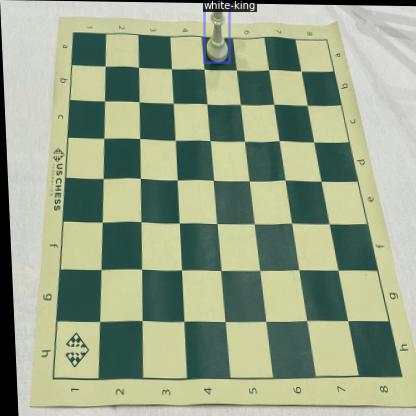

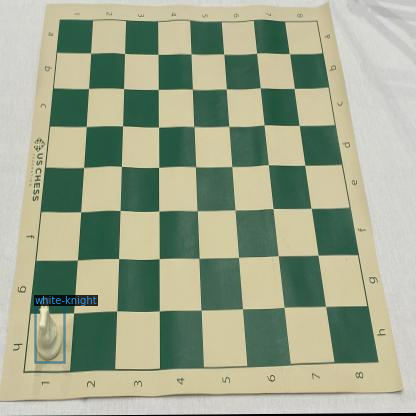

In [ ]:

my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=1.0)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# ***2. Load one of the following pretrained models, then run the test code.***

## > Load R50-FPN, 500 iterations

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate

cfg.SOLVER.WARMUP_ITERS = 300
cfg.SOLVER.MAX_ITER = 500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (300, 500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14 # No. of classes = [HINDI, ENGLISH, OTHER]

cfg.TEST.EVAL_PERIOD = 500 # No. of iterations after which the Validation Set is evaluated. 
cfg.TEST.DETECTIONS_PER_IMAGE = 64 ##

cfg.MODEL.WEIGHTS = "/content/Locating-and-Classifying-Chess-Pieces/models/R_50_FPN_3x_500iters.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.DATASETS.TRAIN = ("my_dataset_train",)

test_metadata = MetadataCatalog.get("my_dataset_test")

key = "instances"

## > Load R50-FPN, 4000 iterations

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate

cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 4000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (500, 4000)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14 # No. of classes = [HINDI, ENGLISH, OTHER]

cfg.TEST.EVAL_PERIOD = 500 # No. of iterations after which the Validation Set is evaluated. 
cfg.TEST.DETECTIONS_PER_IMAGE = 64 ##

cfg.MODEL.WEIGHTS = "/content/Locating-and-Classifying-Chess-Pieces/models/faster_rcnn_R_50_FPN_3x_4000iters.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.DATASETS.TRAIN = ("my_dataset_train",)

test_metadata = MetadataCatalog.get("my_dataset_test")

key = "instances"

## > Load X101-FPN, 2000 iterations

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))# modify model here
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.005

cfg.SOLVER.WARMUP_ITERS = 1800
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1800, 2000)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14

cfg.TEST.EVAL_PERIOD = 500
cfg.TEST.DETECTIONS_PER_IMAGE = 64

cfg.MODEL.WEIGHTS = "/content/Locating-and-Classifying-Chess-Pieces/models/faster_rcnn_X_101_32x8d_FPN_3x_2000iters.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85

test_metadata = MetadataCatalog.get("my_dataset_test")

key = "instances"

## > Load RPN_R_50_1x

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/rpn_R_50_FPN_1x.yaml"))# modify model here
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.005


cfg.SOLVER.WARMUP_ITERS = 1800
cfg.SOLVER.MAX_ITER = 2500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1800, 2500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14

cfg.TEST.EVAL_PERIOD = 500
cfg.TEST.DETECTIONS_PER_IMAGE = 64

cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Chess Net/rpn_R_50_FPN_1x/4000/rpn_R_50_FPN_1x_4000iters_model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85

test_metadata = MetadataCatalog.get("my_dataset_test")

key = "proposals"

# ***3. Run Model on Custom Data***

### Adjust threshold

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

### Run model

In [ ]:
predictor = DefaultPredictor(cfg)

for imageName in glob.glob('/content/drive/MyDrive/Chess Net/Custom Test Dataset/*png'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5, instance_mode=ColorMode.SEGMENTATION)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

UnpicklingError: ignored